In [21]:
#Standard imports
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u
import corner
import fitsio
import kcorrect.kcorrect
from vast.voidfinder.postprocessing import open_fits_file
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import colorConverter
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)

In [2]:
from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder.voidfinder_functions import xyz_to_radecz
from vast.voidfinder.voidfinder import ra_dec_to_xyz
from vast.voidfinder._voidfinder_cython_find_next import MaskChecker
from vast.voidfinder.multizmask import generate_mask

Import the full DESI BGS and SDSS DR7 catalogs in their overlapping region

In [4]:
iron_spec_path = "/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron.fits"
with fitsio.FITS(iron_spec_path) as iron:
    
    print("reading data")
    redshifts = iron[2]['Z','ZWARN','DELTACHI2','SPECTYPE','RA','DEC','BGS_TARGET',#'FLUX_R'
                       ][:]
    fastspec = iron[1]['ABSMAG01_SDSS_U','ABSMAG01_IVAR_SDSS_U',
                       'ABSMAG01_SDSS_R','ABSMAG01_IVAR_SDSS_R',
                       'ABSMAG01_SDSS_G','ABSMAG01_IVAR_SDSS_G',
                       'ABSMAG01_SDSS_I','ABSMAG01_IVAR_SDSS_I',
                       'ABSMAG01_SDSS_Z','ABSMAG01_IVAR_SDSS_Z'
                      ][:]
    #E-correction
    #fastspec['ABSMAG_SDSS_R'] += 0.97*(redshifts['Z']-0.1)
    #magnitude cut
    print(len(fastspec),"target observations read in")
    
    print("Imposing redshift limits")
    select = np.where((redshifts['Z']>0) 
                   & (redshifts['Z']<=0.114) 
                   & (redshifts['SPECTYPE']=='GALAXY') 
                   & (redshifts['BGS_TARGET'] & 2**1 != 0) #BGS bright
                   #& (fastspec['ABSMAG_SDSS_R'] < -20) #Absolute magnitude cut
                 )

    redshifts=redshifts[select]
    fastspec=fastspec[select]
    print(len(fastspec),"targets kept within redshift limits")
    
    """print("Cutting on redshift fit quality")
    select = np.where((redshifts['ZWARN']==0) 
                       & (redshifts['DELTACHI2']>30) 
                     )
    redshifts=redshifts[select]
    fastspec=fastspec[select]
    print(len(fastspec),'targets survive redshift fit cut')"""
    
    desi_gals = Table([redshifts['RA'],redshifts['DEC'],redshifts['Z'],
                  fastspec['ABSMAG01_SDSS_U'],fastspec['ABSMAG01_IVAR_SDSS_U'],
                  fastspec['ABSMAG01_SDSS_R'],fastspec['ABSMAG01_IVAR_SDSS_R'],
                  fastspec['ABSMAG01_SDSS_G'],fastspec['ABSMAG01_IVAR_SDSS_G'],
                  fastspec['ABSMAG01_SDSS_I'],fastspec['ABSMAG01_IVAR_SDSS_I'],
                  fastspec['ABSMAG01_SDSS_Z'],fastspec['ABSMAG01_IVAR_SDSS_Z'],
                  #redshifts['FLUX_R']
                 ],
                names = ['ra','dec','redshift',
                         'uabsmag','uinvar',
                         'rabsmag','rinvar',
                         'gabsmag','ginvar',
                         'iabsmag','iinvar',
                         'zabsmag','zinvar',
                         #'flux'
                        ])

desi_gals['Rgal']=z_to_comoving_dist(desi_gals['redshift'].astype(np.float32),.315,1)
tmp = ra_dec_to_xyz(desi_gals)
desi_gals['x']=tmp[:,0]
desi_gals['y']=tmp[:,1]
desi_gals['z']=tmp[:,2]




reading data
17995820 target observations read in
Imposing redshift limits
840280 targets kept within redshift limits


In [3]:
# Read in SDSS galaxies
sdss_path = '/global/homes/h/hrincon/sdss_compare/nsa_v1_0_1.fits'
sdss_gals = Table.read(sdss_path) # Downloaded from https://live-sdss4org-dr13.pantheonsite.io/manga/manga-target-selection/nsa/

# get k correction coefficients
coeffs = sdss_gals['ELPETRO_KCOEFF']

# select desired table columns
sdss_gals = Table(data=[sdss_gals['RA'], sdss_gals['DEC'], sdss_gals['Z'], sdss_gals["IN_DR7_LSS"],
                        #sdss_gals['ELPETRO_FLUX'][:,4], 
                        sdss_gals['ELPETRO_ABSMAG'][:,2], sdss_gals['ELPETRO_AMIVAR'][:,2],
                        sdss_gals['ELPETRO_ABSMAG'][:,4], sdss_gals['ELPETRO_AMIVAR'][:,4],
                        sdss_gals['ELPETRO_ABSMAG'][:,3], sdss_gals['ELPETRO_AMIVAR'][:,3],
                        sdss_gals['ELPETRO_ABSMAG'][:,5], sdss_gals['ELPETRO_AMIVAR'][:,5],
                        sdss_gals['ELPETRO_ABSMAG'][:,6], sdss_gals['ELPETRO_AMIVAR'][:,6],
                        22.5 - 2.5*np.log10(sdss_gals['ELPETRO_RNMGY'][:,4]),
                        sdss_gals['PLATE'],sdss_gals['MJD'],sdss_gals['FIBERID'],
                       ],
      names=['ra','dec','redshift', 'indr7',
             #'flux_r', 
             'uabsmag','uinvar',
             'rabsmag','rinvar',
             'gabsmag','ginvar',
             'iabsmag','iinvar',
             'zabsmag','zinvar',
             'rappmag',
             'plate','mjd','fiberid'
            ])

sdss_gals_full = sdss_gals

sdss_gals_full['Rgal']=z_to_comoving_dist(sdss_gals_full['redshift'].astype(np.float32),.315,1)
tmp = ra_dec_to_xyz(sdss_gals_full)
sdss_gals_full['x']=tmp[:,0]
sdss_gals_full['y']=tmp[:,1]
sdss_gals_full['z']=tmp[:,2]

coeffs=coeffs[(sdss_gals['redshift']<.114)]
sdss_gals=sdss_gals[(sdss_gals['redshift']<.114)]
coeffs = coeffs[sdss_gals['redshift']>0]
sdss_gals = sdss_gals[sdss_gals['redshift']>0]

responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)

k = kc.kcorrect(redshift=sdss_gals['redshift'], coeffs=coeffs, band_shift=0.1)

sdss_gals['ku']=k[:,0]
sdss_gals['kg']=k[:,1]
sdss_gals['kr']=k[:,2]
sdss_gals['ki']=k[:,3]
sdss_gals['kz']=k[:,4]

sdss_gals = sdss_gals[sdss_gals["indr7"].astype(bool)]

ra_boolean = np.logical_and(sdss_gals["ra"] > 110, 
                            sdss_gals["ra"] < 270)

sdss_gals = sdss_gals[ra_boolean]

strip_boolean = np.logical_and.reduce([sdss_gals["ra"] > 250, 
                                       sdss_gals["ra"] < 269, 
                                       sdss_gals["dec"] > 51, 
                                       sdss_gals["dec"] < 67])

sdss_gals = sdss_gals[~strip_boolean]

/tmp/ipykernel_1701481/2791261866.py:16: RuntimeWarning: divide by zero encountered in log10
  22.5 - 2.5*np.log10(sdss_gals['ELPETRO_RNMGY'][:,4]),


In [238]:
desi_nin_sdss = Table.read('missingGals.txt',format='ascii.commented_header')

In [239]:
desi_nin_sdss_in_sdss = Table.read('missingGalsInfo.fit')

In [30]:
missingID = [str(row['plate']) + ':' + str(row['mjd']) + ':' + str(row['fiberID']) for row in desi_nin_sdss_in_sdss]


In [147]:
sdssID = [str(row['plate']) + ':' + str(row['mjd']) + ':' + str(row['fiberid']) for row in sdss_gals]


In [155]:
# For 649 galaxies in desi not matched to SDSS NSA (see misingGals.txt) in fiducial volume
# 360 are matched to SDSS in CasJobs based on ra-dec matching
# 23 are matched back into NSA from CasJobs based on plate-fiber-mjd matching
np.sum(np.isin(sdssID,missingID)), len(missingID)

(23, 360)

In [159]:
len(np.isin(missingID,match))

360

In [182]:
from astropy.coordinates import position_angle, angular_separation
import astropy.units as u

In [191]:
angular_separation(desi_nin_sdss[match_order]['ra'] * u.deg, desi_nin_sdss[match_order]['dec'] * u.deg,
             sdss_gals[np.isin(sdssID,missingID)]['ra']* u.deg, 
             sdss_gals[np.isin(sdssID,missingID)]['dec'] * u.deg).to(u.arcsec)


<Quantity [5.31949048e+00, 6.38280619e+00, 9.29175948e+04, 1.86834624e+05,
           1.65301030e+05, 2.52842845e+05, 9.69154061e+03, 4.48089958e+03,
           8.55219922e+04, 3.48925908e+05, 3.73066668e+05, 1.23681739e+03,
           8.71815236e+04, 1.40469254e+05, 1.20366436e+05, 3.82544863e+03,
           5.16260531e+03, 2.96215653e+04, 2.21444799e+04, 1.19948399e+03,
           1.75672271e+04, 5.48137466e+03, 1.25047474e+05] arcsec>

In [240]:
# indexes of matches in tmp file
match_order = desi_nin_sdss_in_sdss[np.isin(missingID,sdssID)]['ID']
#desi sky coords
#tmp0[match_order].sort('ra')
desi_nin_sdss[match_order][:5]

ra,dec,ID
float64,float64,int64
170.77262631027648,0.8608925880489401,128
174.4465200769501,0.664116306444786,130
203.49889745859707,0.42987402977900624,114
229.30670202598023,1.120905046587356,174
177.47676509332823,-1.6393447680152264,1


In [200]:
#nsa sky coords
tmp1 = sdss_gals[np.isin(sdssID,missingID)]['ra','dec','plate','mjd','fiberid']
tmp1.sort('ra')
tmp1[:5]

ra,dec,plate,mjd,fiberid
float64,float64,int32,int32,int16
130.88323942628062,3.0848075997118896,564,52224,465
131.697520819076,2.0172216573171666,467,51901,536
170.77404779098043,0.8612966398195804,280,51612,509
174.4452674922054,0.6628614052790075,282,51658,578
177.47621714311745,-1.6439775896631939,329,52056,618


In [170]:
#IDs that match between catalogs
match = np.array(sdssID_masked)[np.isin(sdssID_masked,missingID)]
# indexes of matches in tmp file
match_order = tmp[np.isin(missingID,match)]['ID'][:]
#desi sky coords
tmp0[match_order]

report(tmp0[match_order], sdss_gals[np.isin(sdssID,missingID)]['ra','dec','plate','mjd','fiberid'][:])

# DESI, # SDSS
23 23
SDSS: # in DESI, # not in DESI, % not in DESI
5 18 78.26086956521739
DESI: # in SDSS, # not in SDSS, % not in SDSS
5 18 78.26086956521739
        ra                dec         plate  mjd  fiberid
------------------ ------------------ ----- ----- -------
203.49884813896279  0.430410700630623   298 51955     499
227.97210641933313 2.7097964905036602   540 51996     522
 235.0575166446751 4.2238015406541045  1836 54567     132
241.06916408003977  5.623851367881539  1837 53494     442
236.62222307467678  4.591583272519845  2950 54559     165
        ra                 dec          ID
------------------ ------------------- ---
203.49889745859707 0.42987402977900624 114
227.97227835008445   2.710301550491413 374
 235.0569222423445   4.224159194453079 486
241.06875276094016   5.624115380949081 531
236.62318441169128   4.592147480063568 490
        ra                 dec         plate  mjd  fiberid
------------------ ------------------- ----- ----- -------
170.774047790980

In [80]:
#IDs that match between catalogs
match = np.array(sdssID)[np.isin(sdssID,missingID)]
# indexes of matches in tmp file
match_order = tmp[np.isin(missingID,match)]['ID']
#desi sky coords
tmp0[match_order]

report(tmp0[match_order], sdss_gals_full[np.isin(sdssID,missingID)]['ra','dec'])

# DESI, # SDSS
60 60
SDSS: # in DESI, # not in DESI, % not in DESI
42 18 30.0
DESI: # in SDSS, # not in SDSS, % not in SDSS
42 18 30.0


KeyError: 'plate'

In [ ]:
sdssk1 = Table([sdss_gals['ra'], sdss_gals['dec'], sdss_gals['redshift'], sdss_gals['rabsmag'] - sdss_gals['kr'] + 0.97*(sdss_gals['redshift']-0.1)])


In [17]:
sdssk1.write('nsa_k1.fits')

In [62]:
sdssk1 = Table.read('nsa_k1.fits')

In [7]:
# Number of NSA galaxies in void survey volume
len(sdssk1)

379405

In [6]:
# number of NSA galaxies in volume-limited sample
len(sdssk1[sdssk1['rabsmag']<-20])

177407

In [5]:
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

#Fastspecfit V2.1
print(len(desi_gals),len(sdss_gals))

cat_sdss = SkyCoord(ra = sdss_gals['ra']*u.deg, dec = sdss_gals['dec']*u.deg)
cat_desi = SkyCoord(ra = desi_gals['ra']*u.deg, dec = desi_gals['dec']*u.deg)

index_desi, index_sdss, sep, dist2d = search_around_sky(cat_desi, cat_sdss, 5*u.arcsec)

nindex_sdss = np.ones(len(cat_sdss), bool)
nindex_desi = np.ones(len(cat_desi), bool)
nindex_sdss[index_sdss] = 0
nindex_desi[index_desi] = 0

# SDSS galaxies matched to DESI VS total SDSS galaxies
len(sdss_gals[index_sdss]),len(sdss_gals)

840280 379405


(135679, 379405)

In [38]:
from astropy.coordinates import match_coordinates_3d

# coordinates for desi and sdss
desi_coords = SkyCoord(x=desi_gals['x'], y=desi_gals['y'], z=desi_gals['z'], representation_type='cartesian',unit='Mpc')
sdss_coords = SkyCoord(x=sdss_gals['x'], y=sdss_gals['y'], z=sdss_gals['z'], representation_type='cartesian',unit='Mpc')
# indices into sdss_gals to get the matched points for each point in desi_gals. 
# shape matches desi_gals.  
d_lim = 0.5 # Mpc
idx, sep2d, dist3d = match_coordinates_3d(desi_coords, sdss_coords)
index_sdss_C = idx[np.array(dist3d)<d_lim]
idx, sep2d, dist3d = match_coordinates_3d(sdss_coords, desi_coords)
index_desi_C = idx[np.array(dist3d)<d_lim]


nindex_sdss_C = np.ones(len(sdss_coords), bool)
nindex_desi_C = np.ones(len(desi_coords), bool)
nindex_sdss_C[index_sdss_C] = 0
nindex_desi_C[index_desi_C] = 0


In [43]:
mask_hdul = fits.open('../mask/alt_masks/masks.fits')


In [7]:
from vast.voidfinder._voidfinder_cython_find_next import MaskChecker
def select_mask(gals, mask_hdu, rmin, rmax):
    mask_checker = MaskChecker(0,
                            mask_hdu.data.astype(bool),
                            mask_hdu.header['MSKRES'],
                            rmin,
                            rmax)
    
    points_boolean = np.ones(len(gals), dtype = bool)

    #Flag points that fall outside the mask
    for i in range(len(gals)):
        # The current point
        curr_pt = np.array([gals['x'][i],gals['y'][i],gals['z'][i]])
        # Declare if point is not in mask
        not_in_mask = mask_checker.not_in_mask(curr_pt)
        # Invert not_in_mask to tag points in the mask
        points_boolean[i] = not bool(not_in_mask)
    return gals[points_boolean]

In [8]:
rmin=0
rmax=332.38626

In [22]:
# We do not use this version due to edge effects (SDSS has some wird incomplenteness patterns near it's edges)
desi_gals_masked=select_mask(desi_gals, mask_hdul['COMP'], rmin, rmax)
sdss_gals_masked=select_mask(sdss_gals, mask_hdul['COMP'], rmin, rmax)

In [44]:
# We use this version to remove edge effects
desi_gals_masked=select_mask(desi_gals, mask_hdul['COMPFID'], rmin, rmax)
sdss_gals_masked=select_mask(sdss_gals, mask_hdul['COMPFID'], rmin, rmax)

In [10]:
def report(desi_gals, sdss_gals, return_desi_unique = False):
    #Fastspecfit V2.1
    print("# DESI, # SDSS")
    print(len(desi_gals),len(sdss_gals))

    cat_sdss = SkyCoord(ra = sdss_gals['ra']*u.deg, dec = sdss_gals['dec']*u.deg)
    cat_desi = SkyCoord(ra = desi_gals['ra']*u.deg, dec = desi_gals['dec']*u.deg)

    index_desi, index_sdss, sep, dist2d = search_around_sky(cat_desi, cat_sdss, 5*u.arcsec)
    nindex_sdss = np.ones(len(cat_sdss), bool)
    nindex_desi = np.ones(len(cat_desi), bool)
    nindex_sdss[index_sdss] = 0
    nindex_desi[index_desi] = 0

    
    sdss_in_desi = sdss_gals[index_sdss]
    sdss_nin_desi = sdss_gals[nindex_sdss]
    
    print("SDSS: # in DESI, # not in DESI, % not in DESI")
    print(len(sdss_in_desi),len(sdss_nin_desi),100*len(sdss_nin_desi)/(len(sdss_in_desi)+len(sdss_nin_desi)))
    
    desi_in_sdss = desi_gals[index_desi]
    desi_nin_sdss = desi_gals[nindex_desi]
        
    print("DESI: # in SDSS, # not in SDSS, % not in SDSS")
    print(len(desi_in_sdss),len(desi_nin_sdss),100*len(desi_nin_sdss)/(len(desi_in_sdss)+len(desi_nin_sdss)))
    
    """print(sdss_in_desi)
    print(desi_in_sdss)
    print(sdss_nin_desi)"""
    """print(
    sdss_in_desi[(sdss_in_desi['plate']==298)
                       *(sdss_in_desi['mjd']==51955)
                       *(sdss_in_desi['fiberid']==499)
                      ]
    )
    print(
    sdss_nin_desi[(sdss_nin_desi['plate']==298)
                       *(sdss_nin_desi['mjd']==51955)
                       *(sdss_nin_desi['fiberid']==499)
                      ]
    )"""
    
    if return_desi_unique:
        return desi_nin_sdss

In [106]:
def report_cartesian(desi_gals, sdss_gals):
    #Fastspecfit V2.1
    print("# DESI, # SDSS")
    print(len(desi_gals),len(sdss_gals))

    # coordinates for desi and sdss
    desi_coords = SkyCoord(x=desi_gals['x'], y=desi_gals['y'], z=desi_gals['z'], representation_type='cartesian',unit='Mpc')
    sdss_coords = SkyCoord(x=sdss_gals['x'], y=sdss_gals['y'], z=sdss_gals['z'], representation_type='cartesian',unit='Mpc')
    # indices into sdss_gals to get the matched points for each point in desi_gals. 
    # shape matches desi_gals.  
    d_lim = 0.5 # Mpc
    idx, sep2d, dist3d = match_coordinates_3d(desi_coords, sdss_coords)
    index_sdss = idx[np.array(dist3d)<d_lim]
    idx, sep2d, dist3d = match_coordinates_3d(sdss_coords, desi_coords)
    index_desi = idx[np.array(dist3d)<d_lim]


    nindex_sdss = np.ones(len(sdss_coords), bool)
    nindex_desi = np.ones(len(desi_coords), bool)
    nindex_sdss[index_sdss] = 0
    nindex_desi[index_desi] = 0

    
    sdss_in_desi = sdss_gals[index_sdss]
    sdss_nin_desi = sdss_gals[nindex_sdss]
    
    print("SDSS: # in DESI, # not in DESI, % not in DESI")
    print(len(sdss_in_desi),len(sdss_nin_desi),100*len(sdss_nin_desi)/(len(sdss_in_desi)+len(sdss_nin_desi)))
    
    desi_in_sdss = desi_gals[index_desi]
    desi_nin_sdss = desi_gals[nindex_desi]
    
    #print(desi_nin_sdss)
    
    print("DESI: # in SDSS, # not in SDSS, % not in SDSS")
    print(len(desi_in_sdss),len(desi_nin_sdss),100*len(desi_nin_sdss)/(len(desi_in_sdss)+len(desi_nin_sdss)))
    


In [47]:
# Volume limited, no k or e correction
report(desi_gals_masked[desi_gals_masked['rabsmag']<-20],
    sdss_gals_masked[sdss_gals_masked['rabsmag']<-20]
)

# DESI, # SDSS
7223 9979
SDSS: # in DESI, # not in DESI, % not in DESI
6402 3579 35.85813044785092
DESI: # in SDSS, # not in SDSS, % not in SDSS
6402 823 11.391003460207612


In [48]:
# Volume limited, k + e correction
report(desi_gals_masked[desi_gals_masked['rabsmag']<-20],
    sdss_gals_masked[sdss_gals_masked['rabsmag']-sdss_gals_masked['kr'] + 0.97*(sdss_gals_masked['redshift']-0.1) <-20]
)

# DESI, # SDSS
7223 9125
SDSS: # in DESI, # not in DESI, % not in DESI
6316 2811 30.798729045688617
DESI: # in SDSS, # not in SDSS, % not in SDSS
6316 909 12.581314878892734


In [49]:
# Volume limited, k + e correction, relaxed DESI mag limit
report(desi_gals_masked[desi_gals_masked['rabsmag']<-19.5],
    sdss_gals_masked[sdss_gals_masked['rabsmag']-sdss_gals_masked['kr'] + 0.97*(sdss_gals_masked['redshift']-0.1) <-20]
)

# DESI, # SDSS
12010 9125
SDSS: # in DESI, # not in DESI, % not in DESI
6880 2256 24.69352014010508
DESI: # in SDSS, # not in SDSS, % not in SDSS
6880 5132 42.72394272394273


In [50]:
# Volume limited, k + e correction, relaxed SDSS mag limit
desi_nin_sdss = report(desi_gals_masked[desi_gals_masked['rabsmag']<-20],
    sdss_gals_masked[sdss_gals_masked['rabsmag']-sdss_gals_masked['kr'] + 0.97*(sdss_gals_masked['redshift']-0.1) <-19.5],
    return_desi_unique= True
)

# DESI, # SDSS
7223 12977
SDSS: # in DESI, # not in DESI, % not in DESI
6443 6536 50.35827105323985
DESI: # in SDSS, # not in SDSS, % not in SDSS
6443 782 10.823529411764707


In [52]:
vol = mask_hdul['COMPFID'].header['COVDEG'] / 41252.96 * 4 / 3 * np.pi * rmax ** 3

In [53]:
# DESI Galaxy Average Separation
(len(desi_gals_masked[desi_gals_masked['rabsmag']<-20]) / vol) ** (-1/3)

5.6246493144911565

In [54]:
# SDSS Galaxy Average Separation
(len(sdss_gals_masked[sdss_gals_masked['rabsmag']-sdss_gals_masked['kr'] + 0.97*(sdss_gals_masked['redshift']-0.1) <-20]) / vol) ** (-1/3)

5.2030383962790445

In [61]:
#DESI Survey Volume
desi_rmax = z_to_comoving_dist(np.array([0.24]).astype(np.float32), 0.315, 1)[0] * 1e-3 # convert to Gpc
mask_hdul['DESI'].header['COVDEG'] / 41252.96 * 4 / 3 * np.pi * desi_rmax ** 3

0.08541755346357041

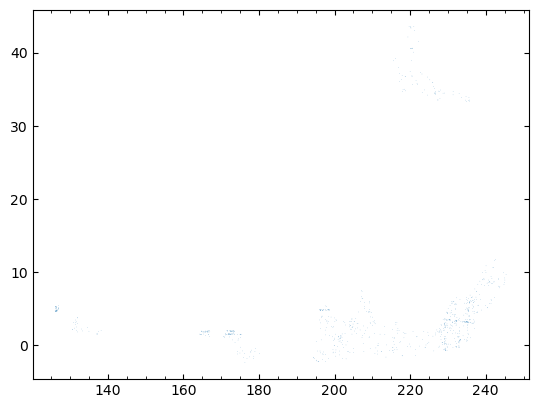

In [35]:
# COMPFID
plt.scatter(desi_nin_sdss['ra'], desi_nin_sdss['dec'],s=.1,edgecolor='none')

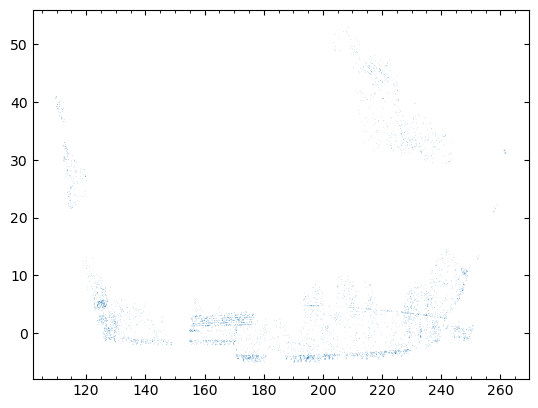

In [30]:
# COMP
plt.scatter(desi_nin_sdss['ra'], desi_nin_sdss['dec'],s=.1,edgecolor='none')

In [ ]:
tmp0 = desi_nin_sdss['ra','dec']
tmp0['ID'] = np.arange(len(tmp))
tmp0.write('missingGals.txt',format='ascii.commented_header')

In [58]:
report_cartesian(desi_gals_masked[desi_gals_masked['rabsmag']<-20],
    sdss_gals_masked[sdss_gals_masked['rabsmag']-sdss_gals_masked['kr'] + 0.97*(sdss_gals_masked['redshift']-0.1) <-19.5]
)

# DESI, # SDSS
6132 10964
SDSS: # in DESI, # not in DESI, % not in DESI
5427 5621 50.87798696596669
DESI: # in SDSS, # not in SDSS, % not in SDSS
5731 795 12.182041066503217


In [22]:


#prepare data for DMP output
graph = plt.hist2d(desi_gals[index_desi]['rabsmag'],sdss_gals[index_sdss]['rabsmag'] - sdss_gals[index_sdss]['kr'], 
           range=[[-22.1,-19.5],[-22.1,-19.5]], bins=120,cmap='Blues')

#save DMP output

dmp_path = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/DESIVAST_figures.fits'
dmp_file = open_fits_file(dmp_path)
hdu = fits.ImageHDU(graph[0])
hdu.name = 'FIG3'
hdu.header['BINEDGE0'] = (graph[1][0], 'Most negative bin edge')
hdu.header['BINEDGE1'] = (graph[1][-1], 'Most positive bin edge')
hdu.header['NUMBIN'] = (len(graph[1]), 'Number of bins per plot axis')
dmp_file.append(hdu)
dmp_file.writeto(dmp_path, overwrite=True)

#clear figure
plt.clf();

<Figure size 640x480 with 0 Axes>

DESI Range:
-20.06 < M_r < -19.89
SDSS Range:
-19.94 < M_r < -20.11


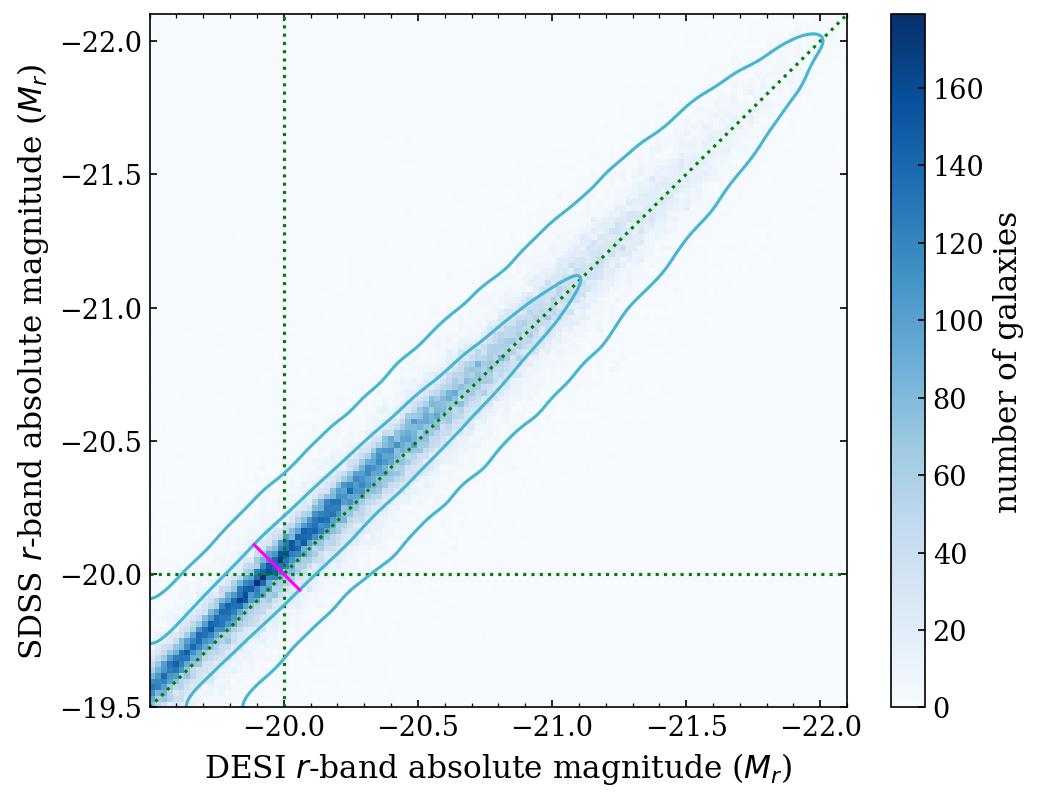

In [6]:
#Plot magnitude comparison

plt.rcParams["font.family"] = "serif"
plt.figure(dpi=150,figsize=(7.5,6))
plt.rcParams["legend.markerscale"] = 10
mpl.rcParams.update({'font.size':13})


#plt.scatter(data[index_desi]['rabsmag'],sdss_gals[index_sdss]['rabsmag'],s=1,edgecolor='None')
graph = plt.hist2d(desi_gals[index_desi]['rabsmag'],sdss_gals[index_sdss]['rabsmag'] - sdss_gals[index_sdss]['kr'], 
           range=[[-22.1,-19.5],[-22.1,-19.5]], bins=120,cmap='Blues')
plt.xlabel("DESI $r$-band absolute magnitude ($M_{r}$)",fontsize=15)
plt.ylabel("SDSS $r$-band absolute magnitude ($M_{r}$)",fontsize=15)

plt.plot([-24,-12],[-24,-12],color='green',alpha=1, linestyle=':')

plt.axhline(-20, color='green', linestyle=':')
plt.axvline(-20, color='green', linestyle=':')

cbar= plt.colorbar(graph[3])
cbar.ax.set_ylabel('number of galaxies',fontsize=15)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

fig = corner.hist2d(desi_gals[index_desi]['rabsmag'], 
            sdss_gals[index_sdss]['rabsmag'] - sdss_gals[index_sdss]['kr'],
            ax = plt.gca(),
            labels=['DESI $M_{r}^{0.1}$','SDSS $M_{r}^{0.1}$'],
            range=[(-19.5,-22.1),(-19.5,-22.1)], 
            bins=200, smooth=4,
            truths=[-20,-20], 
            #truth_color='#ff4444',
            truth_color='gray',#'#eab676',
            levels=(.68, .95), #quantiles=(0.16, 0.84),
            hist_kwargs={'histtype':'step', 'alpha':1},
            color='#48b6d1', # '#48b6d1'
            plot_datapoints=False,
            plot_density = False,
            no_fill_contours = True,
             )

delta_L=.15
delta_H=.19
"""plt.plot([-20-delta_L,-20+delta_H],[-20+delta_L,-20-delta_H],color='green')
print("95% contour along orange line:")
print(-20-delta_L,"< M_r <",-20+delta_H)"""
delta_L=.06
delta_H=.11
plt.plot([-20-delta_L,-20+delta_H],[-20+delta_L,-20-delta_H],color='#ff00ff')
print("DESI Range:")
print(-20-delta_L,"< M_r <",-20+delta_H)
print("SDSS Range:")
print(-20+delta_L,"< M_r <",-20-delta_H)
plt.xticks([-20,-20.5,-21,-21.5,-22]);
plt.savefig("sdss_desi_mag.png", bbox_inches = "tight")

95% contour along orange line:
-20.15 < M_r < -19.81
68% contour along red line:
-20.06 < M_r < -19.89


<Figure size 960x720 with 0 Axes>

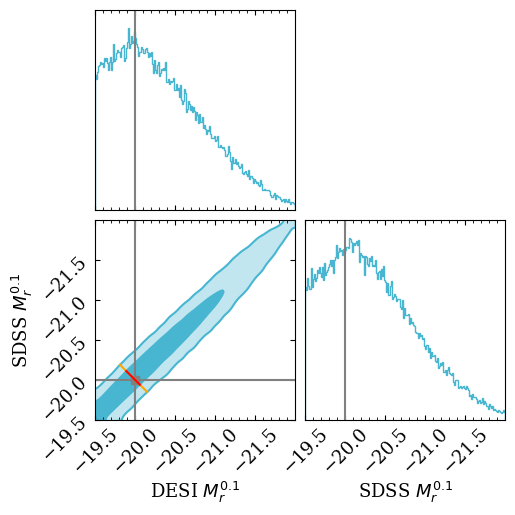

In [26]:
import corner

mpl.rcParams.update({'font.size':13})
plt.rcParams["font.family"] = "serif"
plt.figure(dpi=150)

fig = corner.corner(np.array([desi_gals[index_desi]['rabsmag'],
                              sdss_gals[index_sdss]['rabsmag'] - sdss_gals[index_sdss]['kr']]).T,
                    labels=['DESI $M_{r}^{0.1}$','SDSS $M_{r}^{0.1}$'],
                    range=[(-19.5,-22),(-19.5,-22)], 
                    bins=200, smooth=4,
                    truths=[-20,-20], 
                    #truth_color='#ff4444',
                    truth_color='gray',#'#eab676',
                    levels=(.68, .95), #quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'step', 'alpha':1},
                    color='#48b6d1', plot_datapoints=False,
                    fill_contours=True);
delta_L=.15
delta_H=.19
fig.axes[2].plot([-20-delta_L,-20+delta_H],[-20+delta_L,-20-delta_H],color='orange')
print("95% contour along orange line:")
print(-20-delta_L,"< M_r <",-20+delta_H)
delta_L=.06
delta_H=.11
fig.axes[2].plot([-20-delta_L,-20+delta_H],[-20+delta_L,-20-delta_H],color='red')
print("68% contour along red line:")
print(-20-delta_L,"< M_r <",-20+delta_H)

plt.savefig("sdss_desi_mag_contours.png", bbox_inches = "tight")

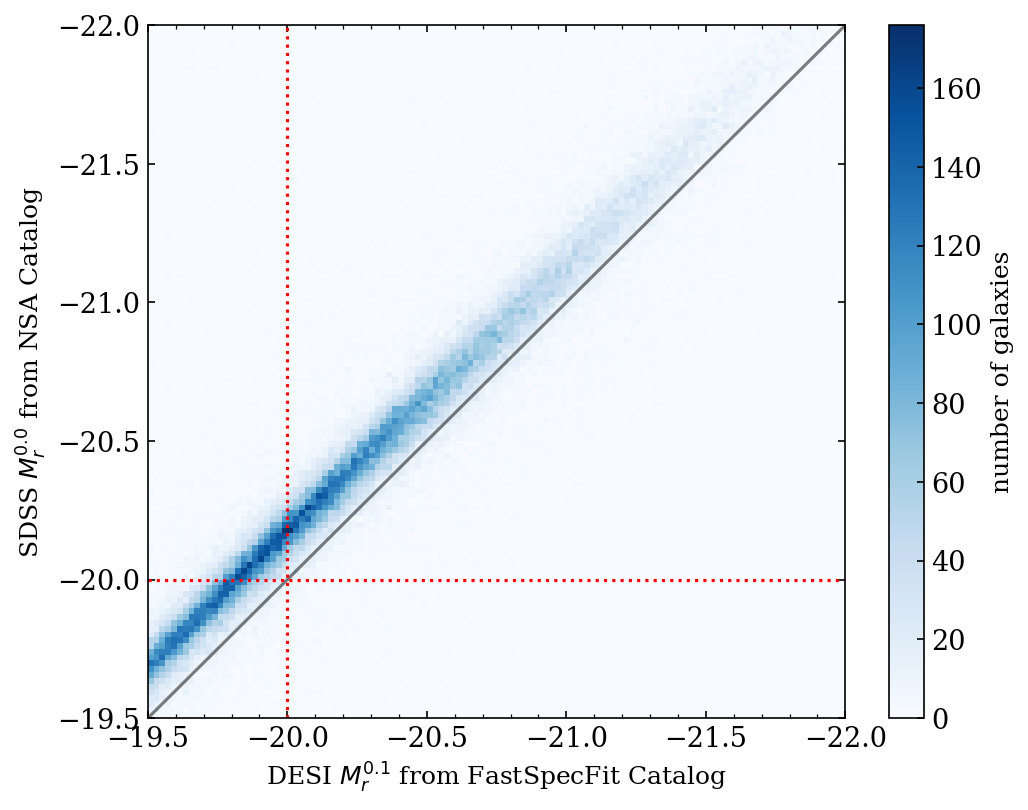

In [24]:
plt.rcParams["font.family"] = "serif"
plt.figure(dpi=150,figsize=(7.5,6))
plt.rcParams["legend.markerscale"] = 10
mpl.rcParams.update({'font.size':13})


#plt.scatter(data[index_desi]['rabsmag'],sdss_gals[index_sdss]['rabsmag'],s=1,edgecolor='None')
graph = plt.hist2d(desi_gals[index_desi]['rabsmag'],sdss_gals[index_sdss]['rabsmag'], 
           range=[[-22,-19.5],[-22,-19.5]], bins=120,cmap='Blues')
plt.xlabel("DESI $M_{r}^{0.1}$ from FastSpecFit Catalog",fontsize=12)
plt.ylabel("SDSS $M_{r}^{0.0}$ from NSA Catalog",fontsize=12)

plt.plot([-24,-12],[-24,-12],color='k',alpha=.5)

plt.axhline(-20, color='r', linestyle=':')
plt.axvline(-20, color='r', linestyle=':')

cbar= plt.colorbar(graph[3])
cbar.ax.set_ylabel('number of galaxies',fontsize=12)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.savefig("sdss_desi_mag_comp.png", bbox_inches = "tight")